# **Import libraries**

In [1]:
import json
import pandas as pd
import os

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # This is the essential 3D import
import numpy as np

# **Initialize variables**

In [2]:
json_file_path = '/content/player_ball_video.json'
output_excel_path = "ball_tracking_data.xlsx"

df = pd.DataFrame(columns=['frame', 'x', 'y', 'confidence'])

In [3]:
if not os.path.exists(json_file_path):
  print(f"Error: Input JSON file not found at {json_file_path}")

try:
  with open(json_file_path, 'r') as f:
    data = json.load(f)
except json.JSONDecodeError:
  print(f"Error: Could not decode JSON from {json_file_path}")
except Exception as e:
  print(f"An unexpected error occurred while reading the JSON file: {e}")

In [4]:
frame_data_key = None

for key, value in data.items():
  if isinstance(value, list) and key not in ['frame_offset', 'time_offset']:
    frame_data_key = key
    break

if not frame_data_key:
    print("Error: Could not find the main prediction data list in the JSON structure.")

In [6]:
extracted_data = []

detection_frames = data.get(frame_data_key, [])

for detection in detection_frames:
  if detection.get('class_id') == 'ball':
    x = (detection.get('x_min')+detection.get('x_max'))/2
    y = (detection.get('y_min')+detection.get('y_max'))/2
    confidence = detection.get('confidence')

    row = {
        'frame': detection.get('frame_id'), # Use frame_id from detection
        'x': x,
        'y': y,
        'confidence': confidence
    }
    extracted_data.append(row)

df = pd.DataFrame(extracted_data)

if df.empty:
  print(f"Warning: No ball detections found in the JSON file.")

try:
  df.to_excel(output_excel_path, index=False, sheet_name='Ball Detections')
  print(f"Successfully extracted {len(extracted_data)} ball detections.")
  print(f"Data saved to Excel file: {output_excel_path}")

except Exception as e:
  print(f"Error occurred while saving to Excel: {e}")

Successfully extracted 167 ball detections.
Data saved to Excel file: ball_tracking_data.xlsx


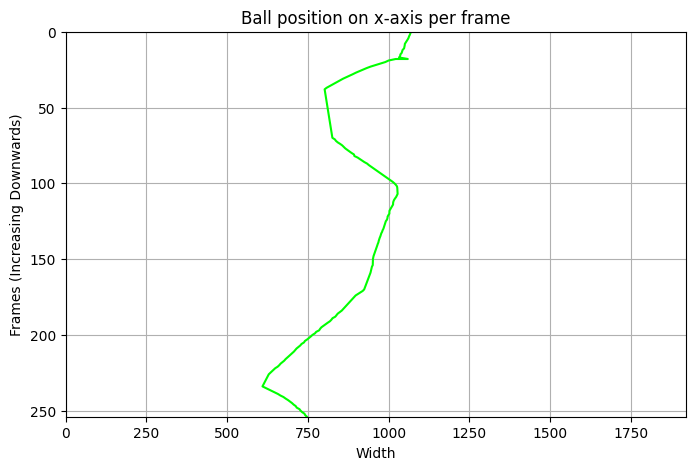

<Figure size 640x480 with 0 Axes>

In [7]:
# Image Size (W, H): (1920, 1080)

plt.figure(figsize=(8, 5))
plt.plot(df['x'], df['frame'], color='lime') # Plotting ball trajectory on x-axis

plt.xlim(0, 1920) # Fix: Use df['x'].max() to get a single maximum value
plt.ylim(len(detection_frames)/3,0)

plt.title('Ball position on x-axis per frame')
plt.xlabel('Width')
plt.ylabel('Frames (Increasing Downwards)')
plt.grid(True)

plt.show()

plt.savefig('x_ball_per_frame_plot.png')

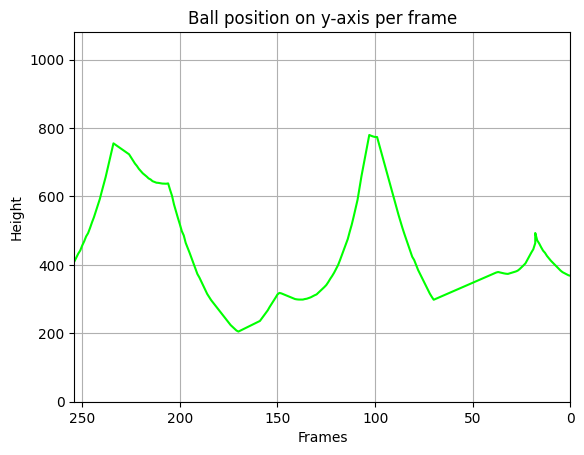

In [8]:
plt.plot(df['frame'], df['y'], color='lime') # Plotting ball trajectory on x-axis

plt.ylim(0, 1080) # Fix: Use df['x'].max() to get a single maximum value
plt.xlim(len(detection_frames)/3,0)

plt.title('Ball position on y-axis per frame')
plt.xlabel('Frames')
plt.ylabel('Height')
plt.grid(True)

plt.savefig('y_ball_per_frame_plot.png')

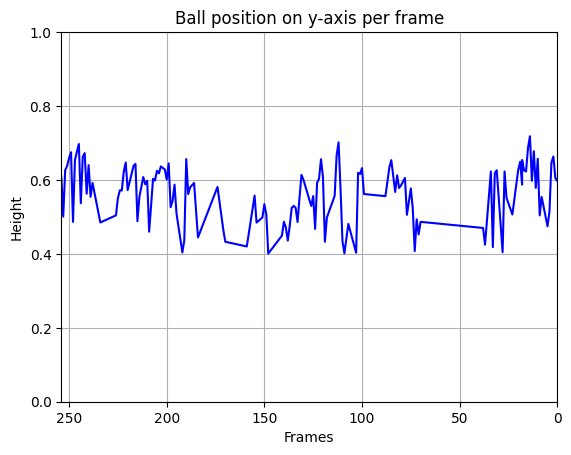

In [9]:
plt.plot(df['frame'], df['confidence'], color='blue') # Plotting ball trajectory on x-axis

plt.ylim(0, 1)
plt.xlim(len(detection_frames)/3,0)

plt.title('Ball position on y-axis per frame')
plt.xlabel('Frames')
plt.ylabel('Height')
plt.grid(True)

plt.savefig('y_ball_per_frame_plot.png')

In [10]:
import pandas as pd
import numpy as np
import plotly.express as px

def create_plotly_3d_scatter(df):
    """
    Creates a highly interactive 3D scatter plot using Plotly Express.
    X = 'x', Y = 'y', Z = 'frame'.

    Args:
        df (pd.DataFrame): The DataFrame containing 'x', 'y', and 'frame' columns.
    """

    # --- 1. Create the Plotly Figure ---
    fig = px.scatter_3d(
        df,
        x='x',            # X-Axis data
        y='frame',            # Y-Axis data
        z='y',        # Z-Axis data (Frame Number)
        color='frame',    # Color the points based on frame number
        title='Interactive 3D Ball Trajectory (Plotly)',
        height=700        # Adjust plot height
    )

    # --- 2. Define Axis Limits and Invert Y-Axis ---

    # Get the required min/max values
    x_min, x_max = 0, 1920
    y_min, y_max = 0, 1080

    # Configure the layout and axes
    fig.update_layout(
        scene = {
            # X-axis limits
            'xaxis': dict(range=[x_min, x_max], title='X Coordinate'),

            # Y-axis limits (Setting y_max first effectively inverts the axis)
            # Plotly handles inversion slightly differently but setting the range
            # often gives the desired look in 3D views.
            'yaxis': dict(range = (0, len(detection_frames)/3), title='Frame Number'),

            # Z-axis limits (Frame number)
            'zaxis': dict(range=[y_min, y_max], title='Y Coordinate'),
        },
        margin=dict(l=0, r=0, b=0, t=50)
    )

    # --- 3. Display the Plot ---
    fig.show()

create_plotly_3d_scatter(df)